In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation
import matplotlib.gridspec as gridspec
from datetime import timedelta

import seaborn as sns
from pprint import pprint

from skimage import feature

from SentinelHubUtils import get_eopatch, delete_frame_eopatch, band_names


In [2]:
df = pd.read_csv('./data/01_removed_outliers/River_Arno.csv', sep=',', header=0, index_col=0)
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.set_index('Date', verify_integrity=True)

In [5]:
river_Arno_dir_1 = './data/03_EO_River_Arno_1'

time_interval = ('2015-01-01', '2018-01-01')
geoPointBotLeft=(43.77185996493141, 11.410335509979328)
geoPointTopRight=(43.775974276342296, 11.415518759375773)

eopatch = get_eopatch(river_Arno_dir_1, (geoPointBotLeft, geoPointTopRight), time_interval)
eopatch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(18, 47, 40, 7), dtype=float32)
    NDVI: numpy.ndarray(shape=(18, 47, 40, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(18, 47, 40, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 47, 40, 1), dtype=uint8)
    CLP: numpy.ndarray(shape=(18, 47, 40, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(18, 47, 40, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(18, 47, 40, 1), dtype=bool)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(18, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.1
    service_type: 'processing'
    size_x: 40
    size_y: 47
    time_difference: datetime.timedelta(days=1)
    time_interval: ('2015-01-01T00:00:00', '2018-01-01T23:59:59')
  }
  bbox: BBox(((11.410335509979328, 43.77185996493141), (11.415518759375773, 43.775974276342296)), crs=CRS('4326'))
  t

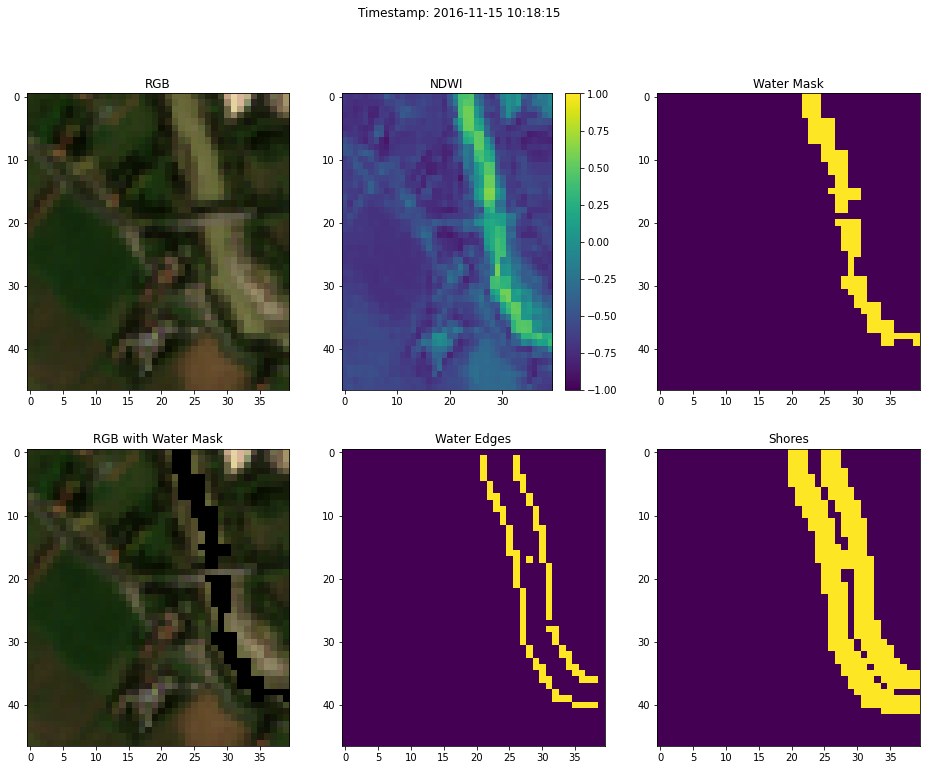

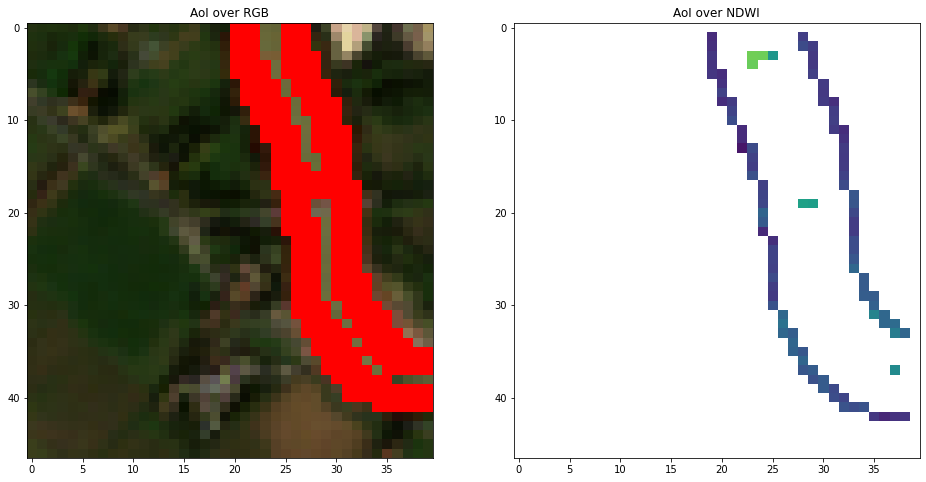

In [10]:
from WaterMaskUtils import get_water_mask, visualise_water_mask

(water_mask, water_edges, shores, shores_edges) = get_water_mask(eopatch, water_treshhold=0.2, canny_sigma=2., gauss_sigma=0.2)

visualise_water_mask(band_names, eopatch, 0, water_mask, water_edges, shores, shores_edges)